# Series de Tiempo - ARIMA

### Importando librería para predicción con series de tiempo


In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from math import sqrt

import matplotlib 
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

### Importando Data

+ Dataset: Pasajeros de aerolínea
+ Unidad: Miles

In [4]:
#Importando la data
url = 'https://raw.githubusercontent.com/JBrianAlicorp/Business-Analytics/master/international-airline-passengers.csv'
df = pd.read_csv(url,encoding='latin1')

In [5]:
df.columns = ['year','passengers']

In [6]:
df.head()

,year,passengers
0,1949-02,118
1,1949-03,132
2,1949-04,129
3,1949-05,121
4,1949-06,135


In [7]:
df.describe()

,passengers
count,143.000000
mean,281.475524
std,119.550851
min,104.000000
25%,180.500000
50%,267.000000
75%,361.000000
max,622.000000


In [8]:
df.dtypes

year          object
passengers     int64
dtype: object

In [9]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-02
Time period end: 1960-12


In [10]:
df.shape

(143, 2)

### 1.Preprocesamiento de data y visualización

**convertimos el formato de fecha:**

In [11]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [12]:
df.dtypes

year          datetime64[ns]
passengers             int64
dtype: object

**Establecer índice como la columna de fecha y hora para manipulaciones más fáciles:**

In [13]:
y = df.set_index('year')

In [14]:
y

,passengers
year,
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [15]:
y.index

DatetimeIndex(['1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01', '1949-11-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=143, freq=None)

In [16]:
y.isnull().sum()

passengers    0
dtype: int64

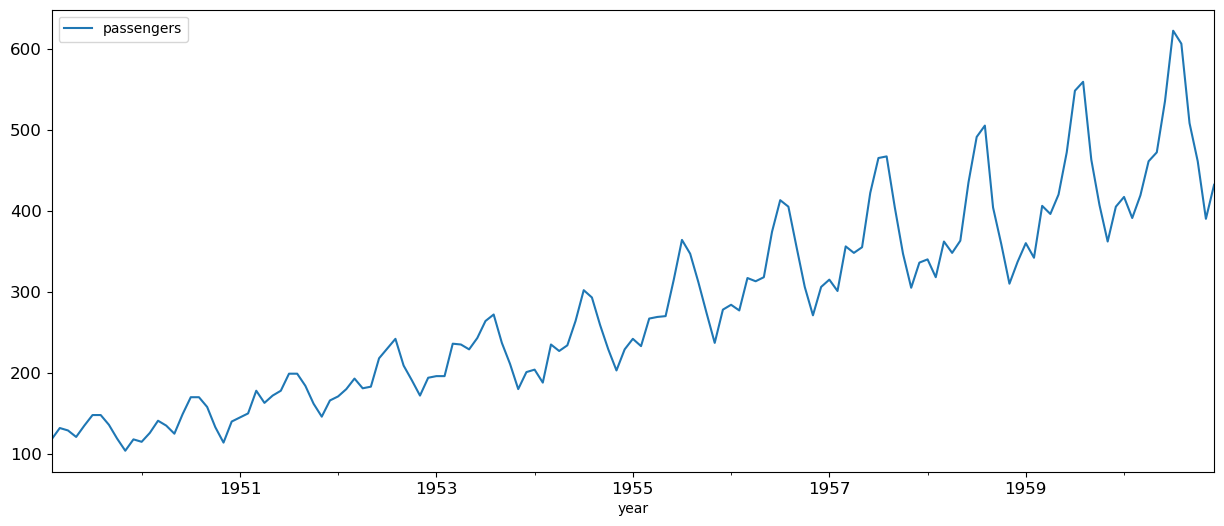

In [17]:
y.plot(figsize=(15 , 6))
plt.show()

**La revisión de los gráficos de la densidad de observaciones puede proporcionar una mayor comprensión de la estructura de los datos:**

+ La distribución no es perfectamente gaussiana (distribución normal).
+ La distribución se deja desplazada.
+ Las transformaciones pueden ser útiles antes del modelado.

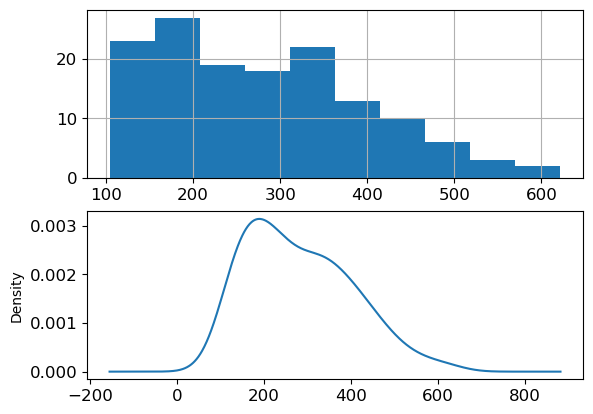

In [18]:
from pandas import Series 
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

**Cajas y bigotes:**

+ Los valores medianos a través de los años confirman una tendencia al alza
+ Aumento constante de la propagación, o 50% medio de los datos (cuadros) con el tiempo 
+ Un modelo que considere la estacionalidad podría funcionar bien

In [19]:
?sns.boxplot

<Axes: xlabel='year', ylabel='passengers'>

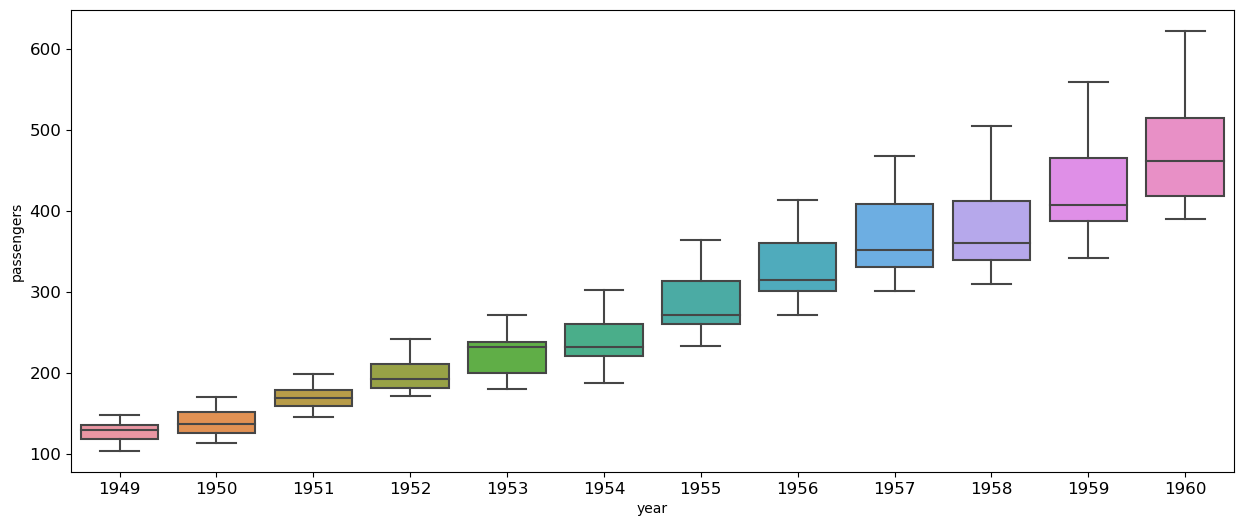

In [20]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=y.passengers.index.year, y=y.passengers, ax=ax)

**Descomponer usando el modelo de estadísticas:**

+ Podemos usar statsmodels para realizar una descomposición de esta series de tiempo.
+ La descomposición de series temporales es una tarea estadística que deconstruye una serie temporal en varios componentes, cada uno de los cuales representa una de las categorías subyacentes de patrones.
+ Con los modeloos de estadísticas podremos ver los componentes de tendencia, estacionales y residuales de nuestros datos.

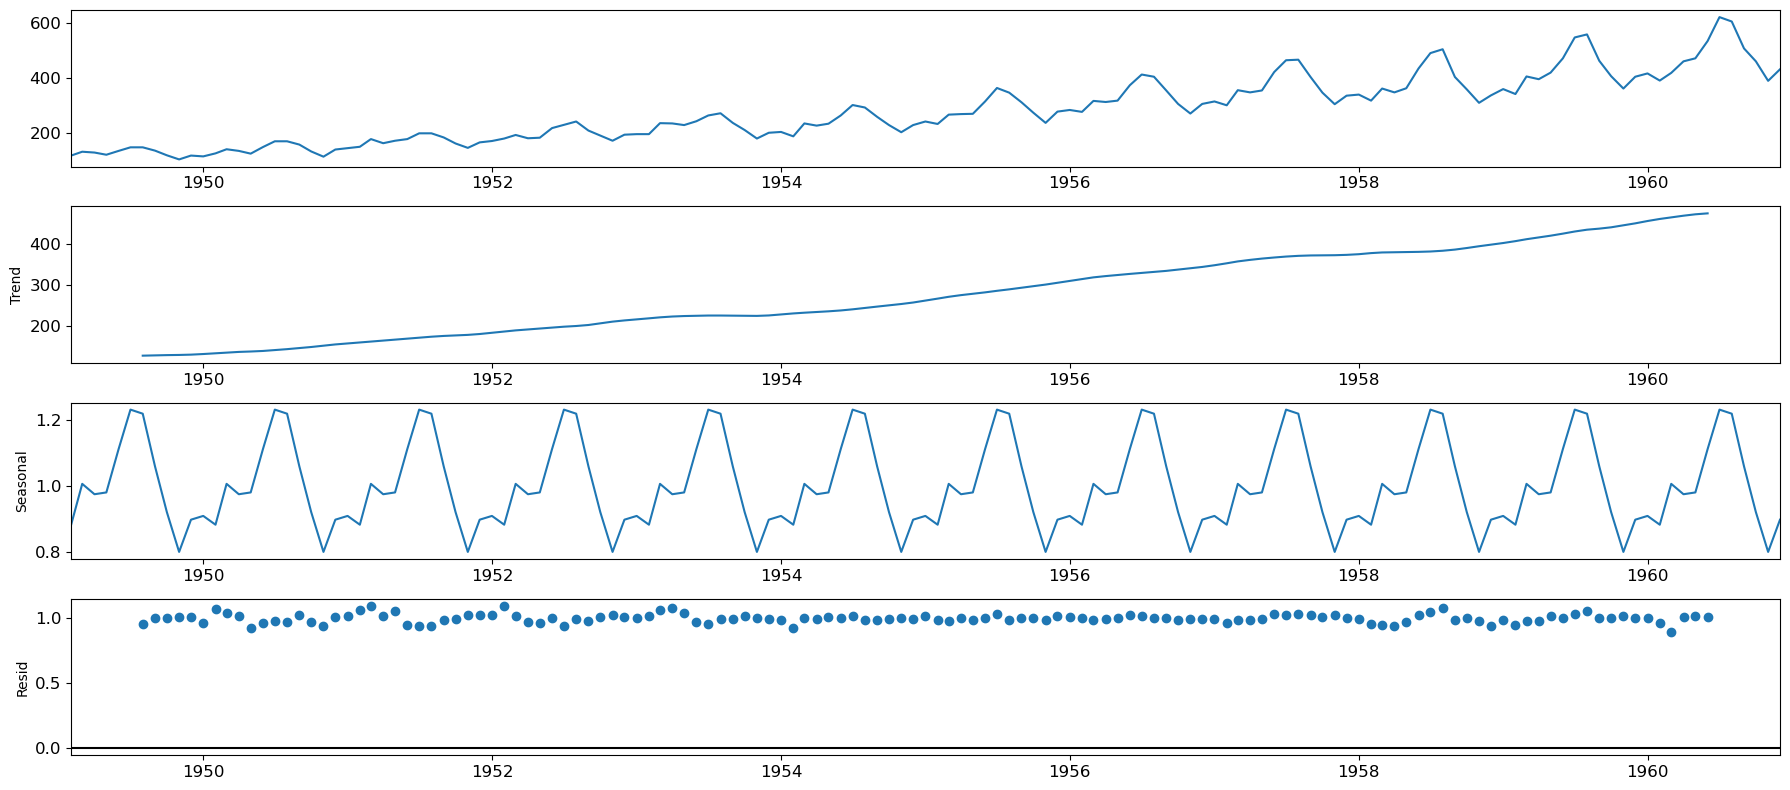

In [21]:
import matplotlib as mpl

decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
mpl.rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

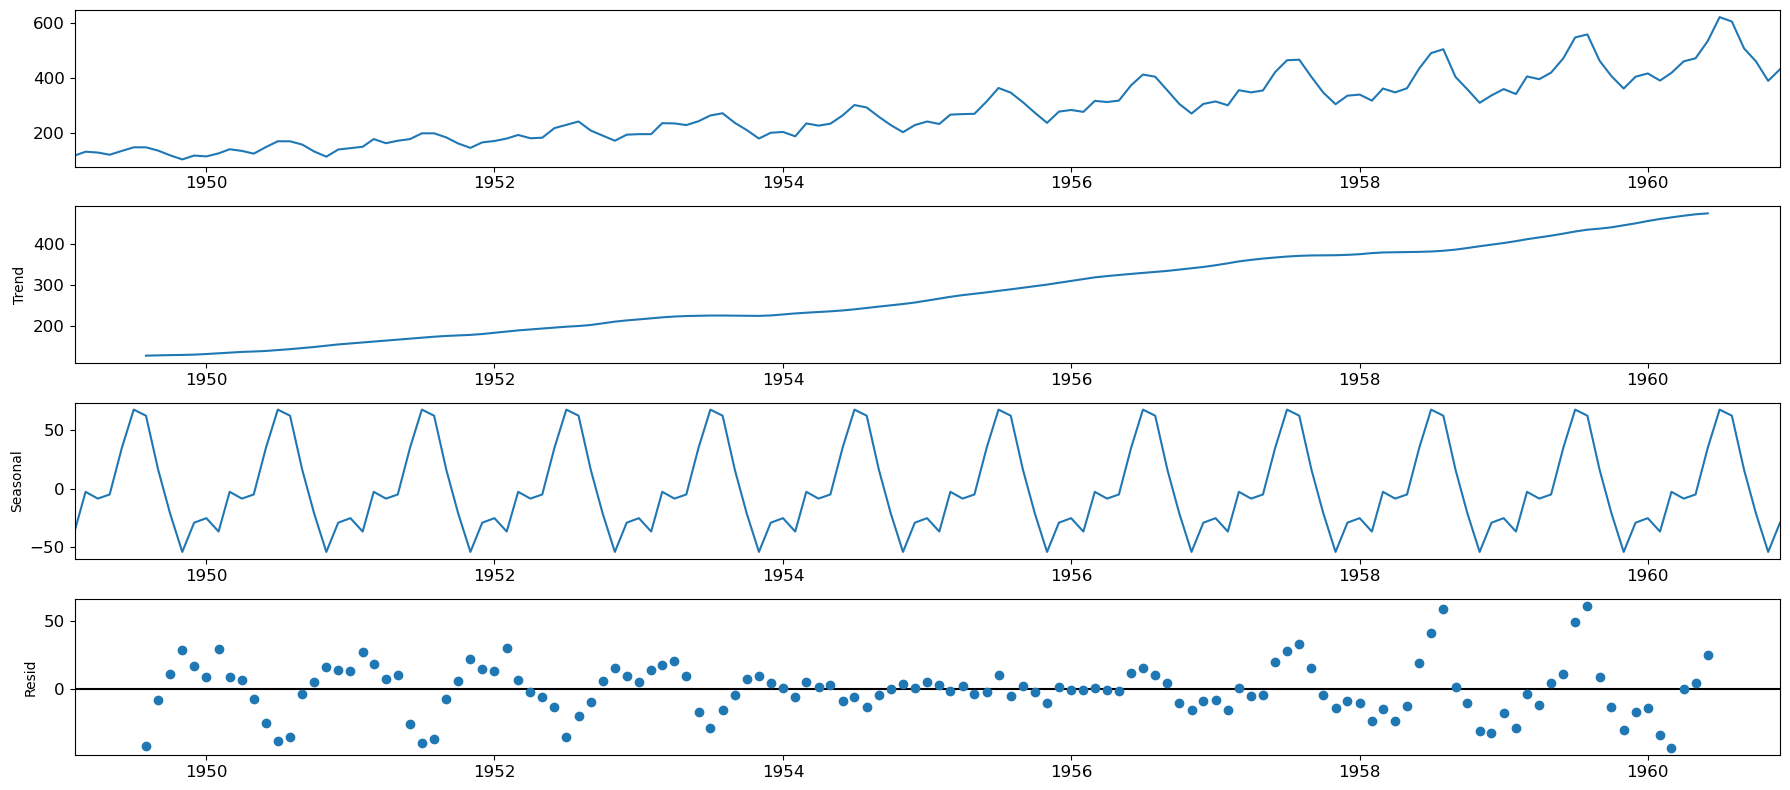

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8 
decomposition = sm.tsa.seasonal_decompose(y, model='aditive')
fig = decomposition.plot()
plt.show()

## 2.Estacionariedad

+ Se dice que una serie temporal es estacionaria si sus propiedades estadísticas, como la media, la varianza permanecen constantes en el tiempo. 
+ La mayoría de los modelos de series temporales funcionan bajo el supuesto de que el TS es estacionario. La razón principal de esto es que hay muchas formas en que una serie puede ser no estacionaria, pero solo una forma de estacionariedad.
+ Intuitivamente, podemos decir que si una serie temporal tiene un comportamiento particular a lo largo del tiempo, hay una probabilidad muy alta de que siga igual en el futuro.
+ Además, las teorías relacionadas con las series estacionarias son más maduras y más fáciles de implementar en comparación con las series no estacionarias.

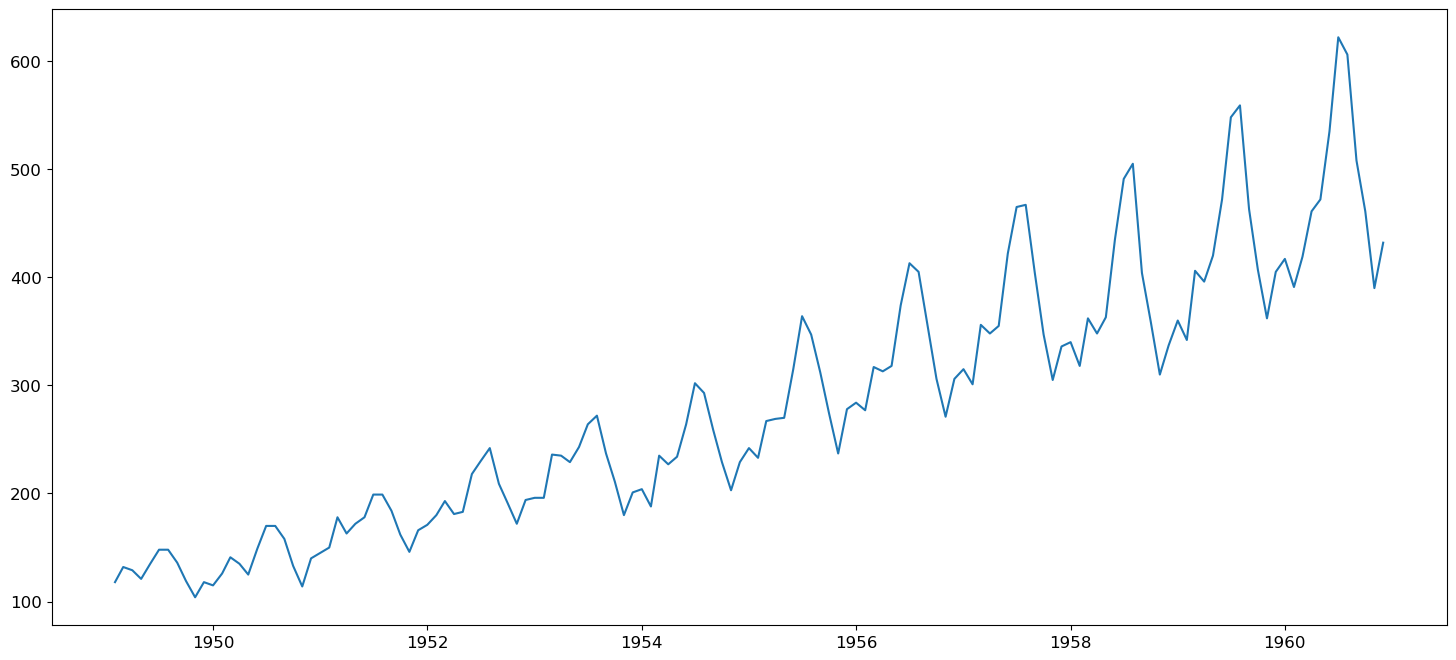

In [23]:
plt.plot(y)
plt.show()

**Podemos verificar la estacionariedad utilizando lo siguiente:**

+ **Gráficos ACF y PACF:** Si la serie temporal es estacionaria, los gráficos ACF / PACF mostrarán una **disminución rápida de la correlación** después de una pequeña cantidad de retraso entre los puntos.
+ **Plotting Rolling Statistics**: Podemos trazar el promedio móvil o la varianza móvil y ver si varía con el tiempo. La media móvil / varianza es para cualquier "t" instantánea, la media / varianza del último año, es decir, los últimos 12 meses.
+ **Prueba de Dickey-Fuller aumentada:** Esta es una de las pruebas estadísticas para verificar la estacionariedad. Aquí la hipótesis nula es que el TS no es estacionario. Los resultados de la prueba se componen de una estadística de prueba y algunos valores críticos para niveles de confianza diferentes. Si el "Estadístico de prueba" es menor que el "Valor crítico", podemos rechazar la hipótesis nula y decir que la serie es estacionaria. Consulte este artículo para más detalles.

## Gráficos ACF y PACF

+ Repasemos los gráficos de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF)
+ Si la serie temporal es estacionaria, los gráficos ACF / PACF mostrarán una **disminución rápida de la correlación** después de una pequeña cantidad de retraso entre los puntos.
+ Estos datos no son estacionarios, ya que un gran número de observaciones anteriores están correlacionadas con valores futuros.
+ Los intervalos de confianza se dibujan como un cono.
+ De forma predeterminada, esto se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.
+ La autocorrelación parcial en el retraso k es la correlación que resulta después de eliminar el efecto de cualquier correlación debido a los términos en los retrasos más cortos.

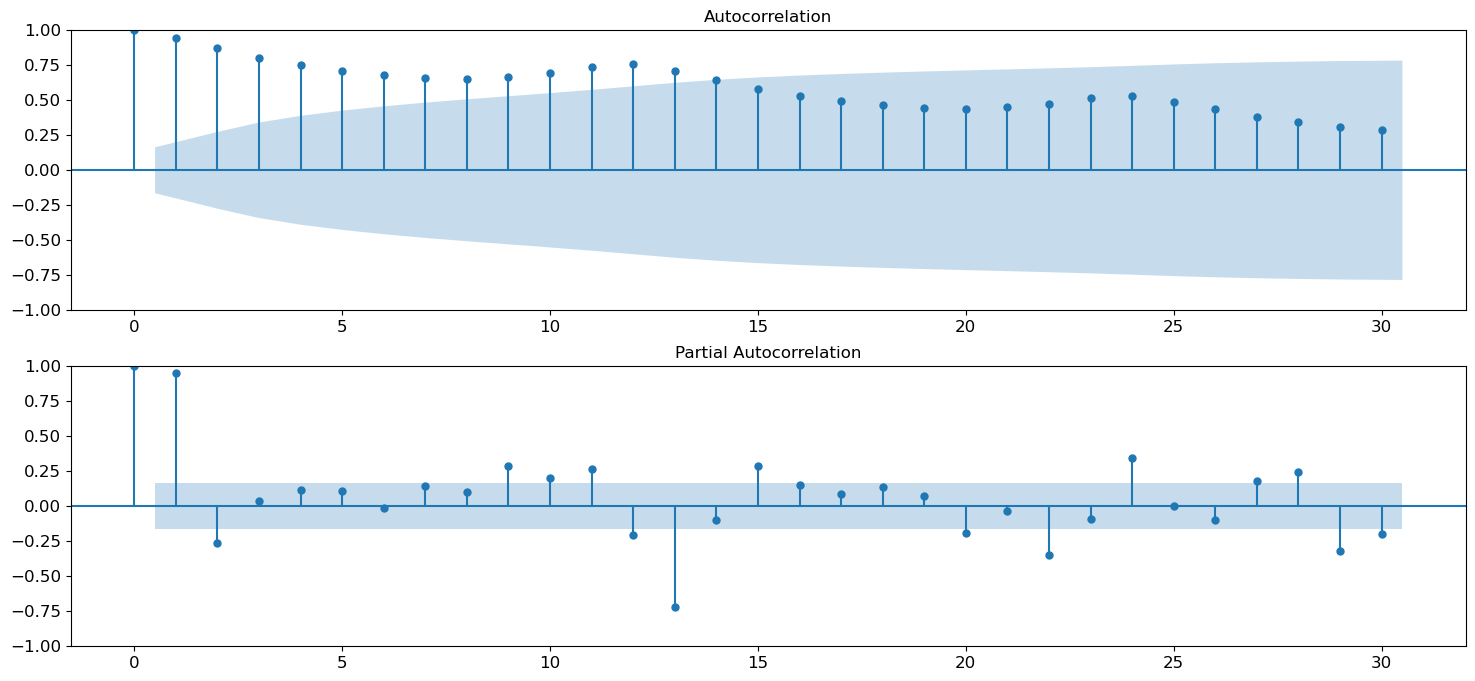

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

## Graficando estadísticas continuas 

+ Observamos que la media móvil y la desviación estándar no son constantes con respecto al tiempo (tendencia creciente)
+ Por lo tanto, la serie temporal no es estacionaria

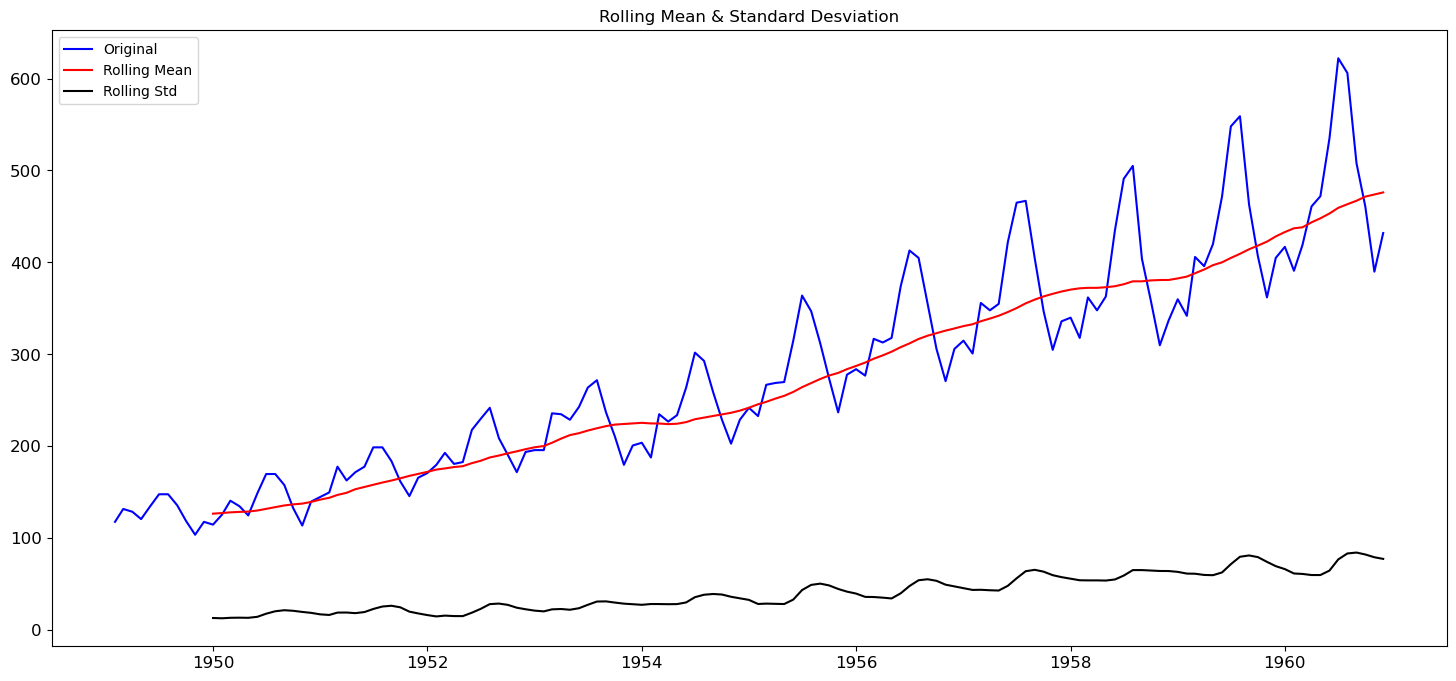

In [25]:
# Determinar estadísticas continuas
rolmean = y.rolling(12).mean()
rolstd = y.rolling(12).std()

#Graficando estadísticas continuas
orig = plt.plot(y, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label= 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Desviation')
plt.show(block=False)

## Prueba de Dickey-Fuller aumentada

+ La intuición detrás de la prueba es que la serie está integrada, entonces el nivel rezagado de la serie y (t-1) no proporcionará información relevante para predencir el cambio en y (t).
+ Hipótesis nula: la serie temporal no es estacionaria
+ Rechazar la hipótesis nula (es decir, un valor p muy bajo) indicará estacionariedad

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.792340
p-value                          0.991512
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


## Hacer series temporales estacionarias

Hay 2 razones principales detrás de la no estacionaria de un TS:

1. **Trend** - media variable con el tiempo. Por ejemplo, en este caso vimos que, en promedio, el número de pasajeros crecía con el tiempo.
2. **Estacionalidad** - variaciones en marcos de tiempo específicos. Por ejemplo, las personas pueden tener tendencia a comprar automóviles en un mes en particular debido a un incremento salarial o festivales.

### Transformaciones

+ Podemos aplicar transformaciones que penalizan los valores más altos más que los valores más pequeños. Estos pueden tomar un registro, raíz cuadrada, raíz cúbica, etc. Tomemos una transformación de registro aquí por simplicidad:

**Transformación logarítmica**

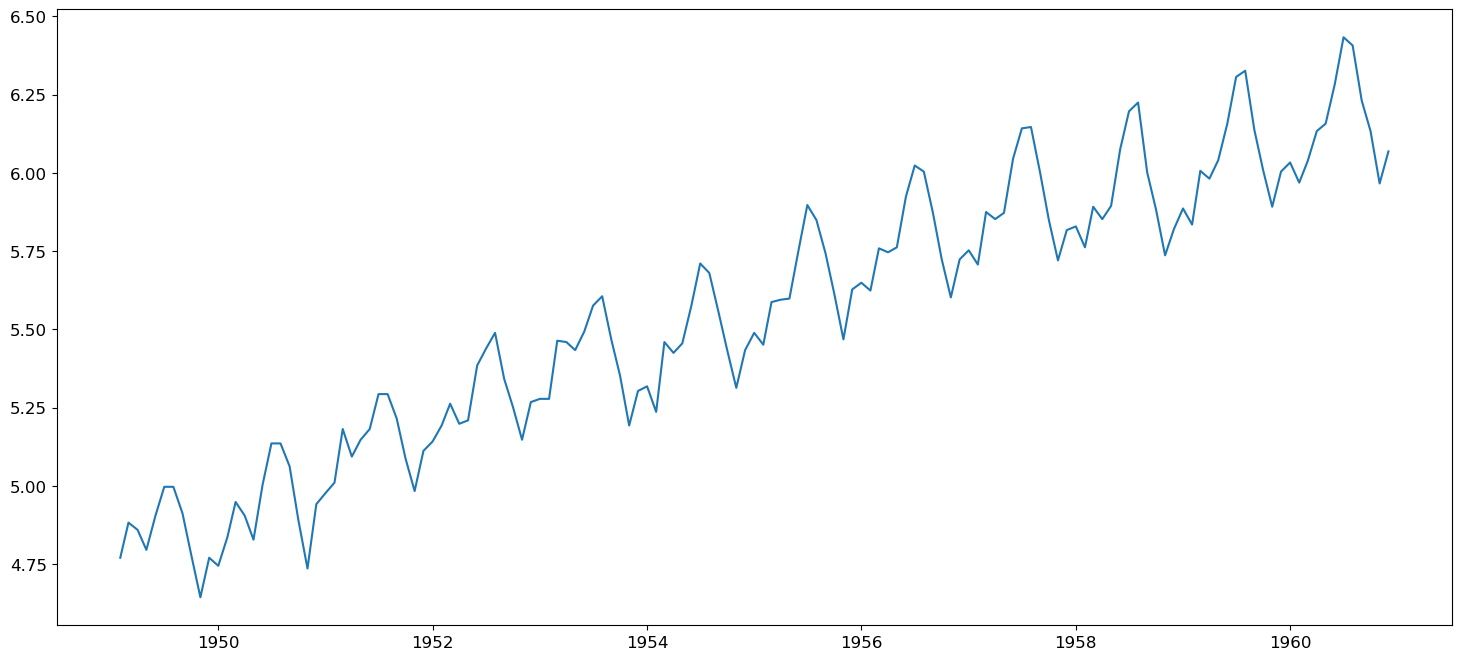

In [28]:
ts_log = np.log(y)
plt.plot(ts_log)
plt.show()

**Otras posibles transformaciones:**

+ Transformación exponencial
+ Transformación de Box Cox
+ Transformación de raíz cuadrada

### Técnicas para eliminar Tendencia - Suavizado

+ Alisar es tomar promedios continuos en ventanas de tiempo
<br><br>


**Media móvil**
+ Tomamos un promedio de "k" valores consecutivos dependiendo de la frecuencia de las series de tiempo.
+ Aquí podemos tomar el promedio durante el último año, es decir, los últimos 12 valores.
+ Un inconveniente de este enfoque particular es que el período de tiempo debe definirse estrictamente.

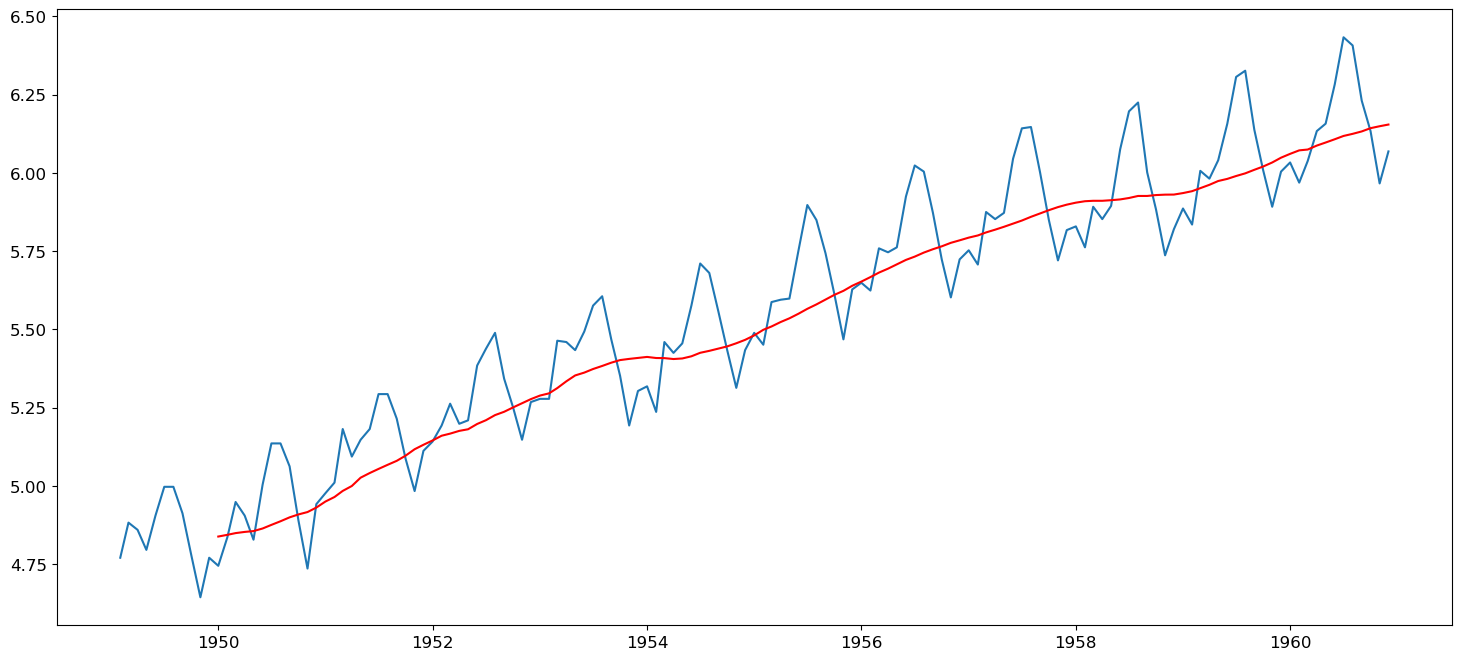

In [29]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

In [30]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(15)

year
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01         NaN
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: passengers, dtype: float64

## Técnicas adicionales para eliminar la estacionalidad y la tendencia

+ Las técnicas simples de reducción de tendencias discutidas antes no funcionan en todos los casos, particularmente en aquellas con alta estacionalidad.

**Diferenciación**
+ En esta técnica, tomamos la diferencia de la observación en un instante particular con la del instante anterior.
+ Diferenciación de primer orden en pandas


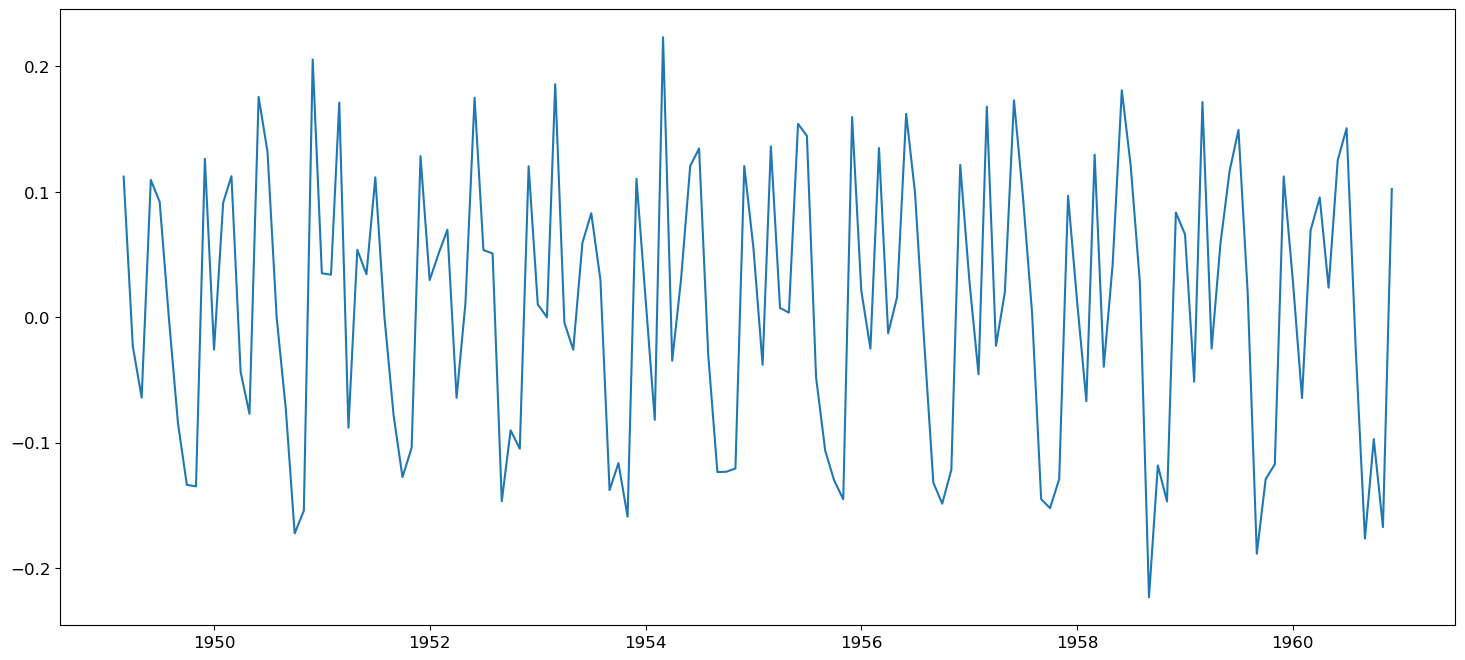

In [31]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)
plt.show()

**Descomposición**
+ En este enfoque, tanto la tendencia como la estacionalidad se modelan por separado y se devuelve la parte restante de la serie.

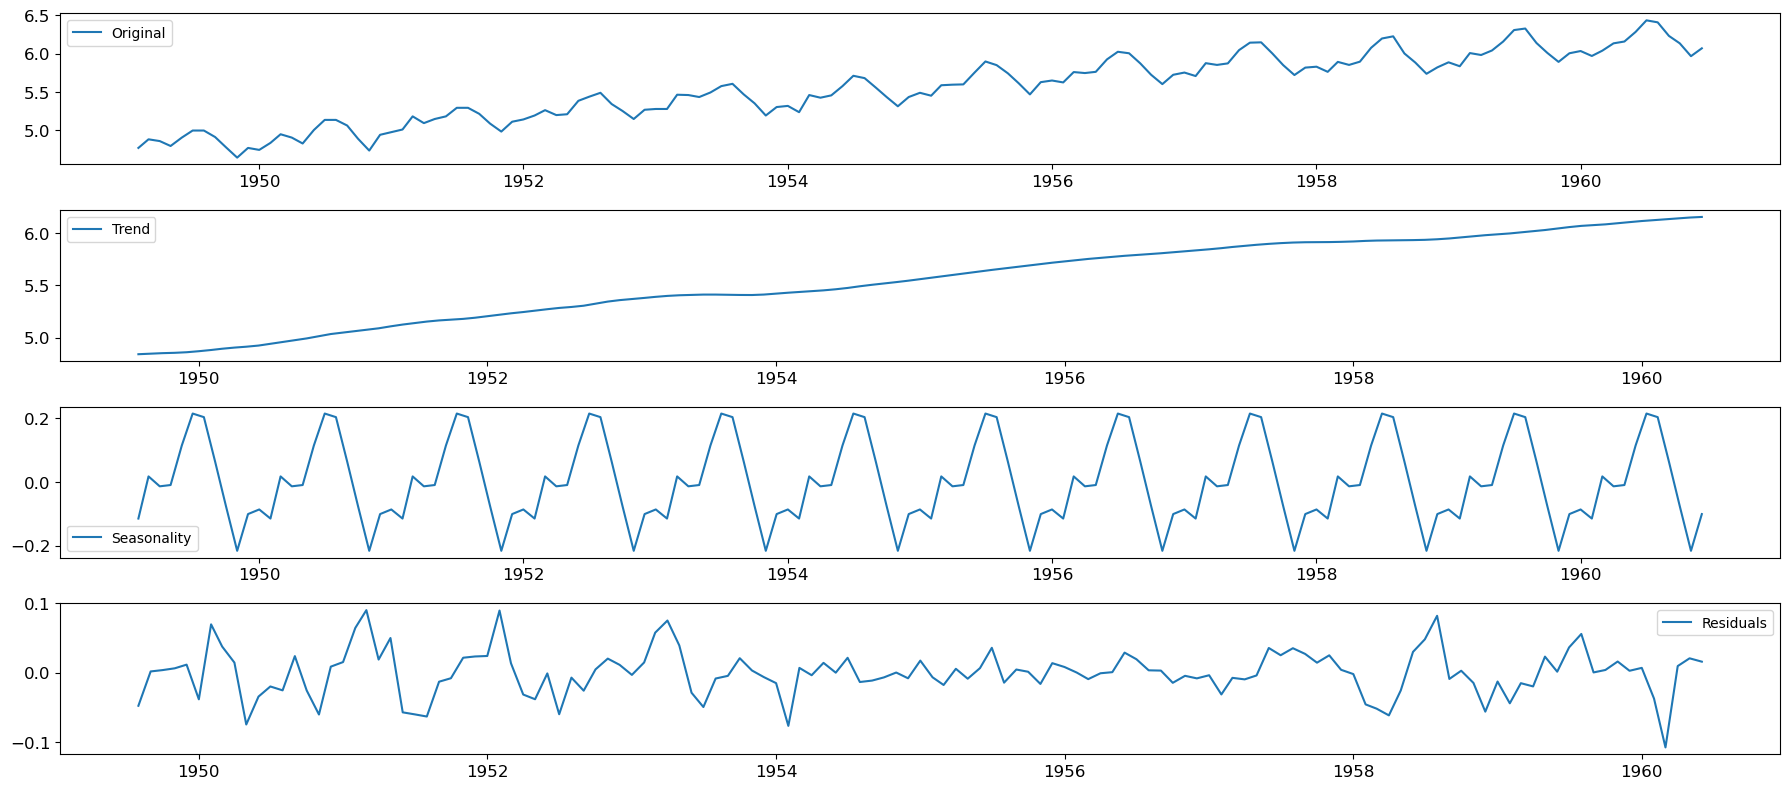

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## 3.Predicción de series de tiempo

## Autoregresión (AR)
+ El método de autoregresión (AR) modela el siguiente paso de la secuencia como una función lineal de las observaciones en los pasos de tiempo anteriores.
+ **Número de términos AR (Auto-regresivos)(p):** p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x(t) serán x(t-1)... .x(t-5).

In [33]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from random import random

In [34]:
ts_log_diff = ts_log_diff.dropna()

In [35]:
# fit model
model = AutoReg(ts_log_diff, 3, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:             passengers   No. Observations:                  142
Model:                     AutoReg(3)   Log Likelihood                 118.809
Method:               Conditional MLE   S.D. of innovations              0.103
Date:                Tue, 15 Aug 2023   AIC                           -227.618
Time:                        01:22:47   BIC                           -212.945
Sample:                    06-01-1949   HQIC                          -221.655
                         - 12-01-1960                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0098      0.009      1.107      0.269      -0.008       0.027
passengers.L1     0.2200      0.085      2.596      0.009       0.054       0.386
passengers.L2    -0.1461      0.087     

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


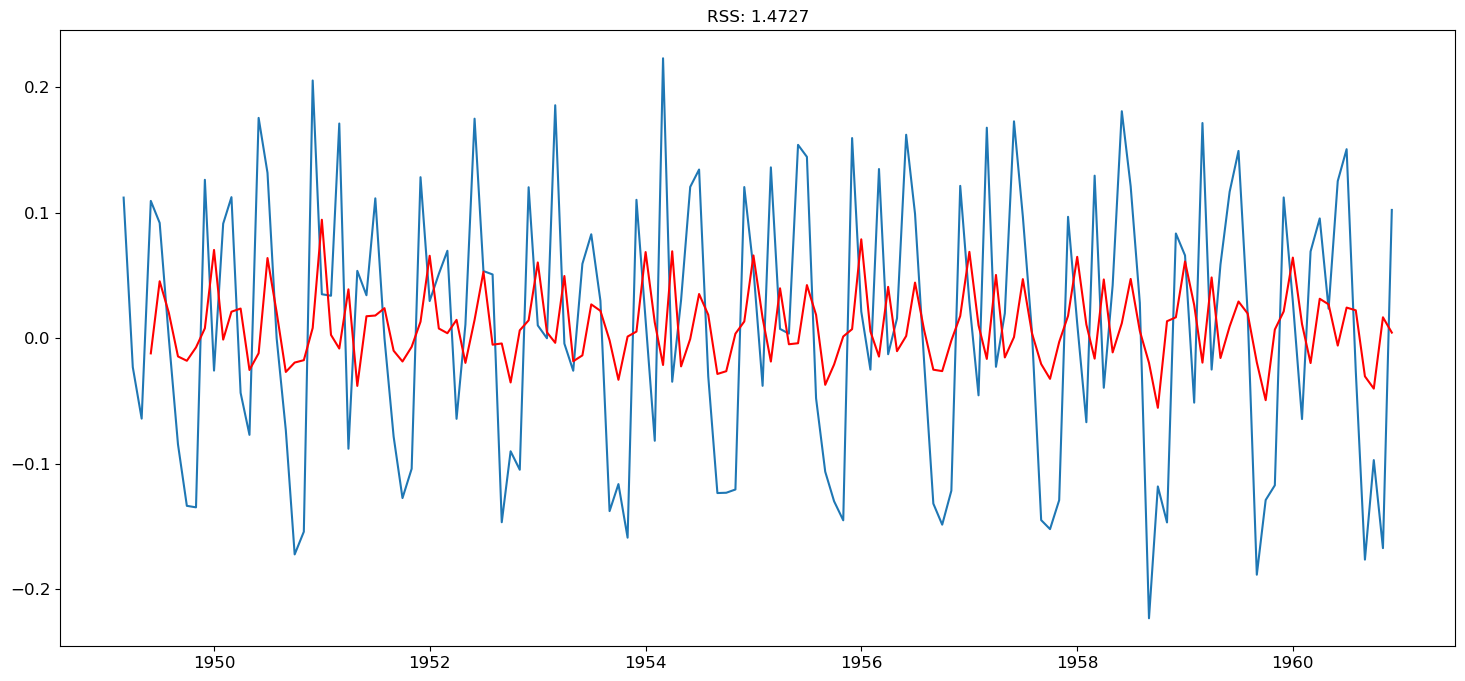

In [36]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

## Revirtiendo las transformaciones

**Valores ajustados o predichos:**

In [37]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

year
1949-06-01   -0.012034
1949-07-01    0.045464
1949-08-01    0.020308
1949-09-01   -0.014472
1949-10-01   -0.017920
dtype: float64


**Suma acumulativa para revertir la diferenciación:**

In [38]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

year
1949-06-01   -0.012034
1949-07-01    0.033430
1949-08-01    0.053738
1949-09-01    0.039266
1949-10-01    0.021346
dtype: float64


**Agregar el valor del primer mes que se eliminó previamente al diferenciar:**

In [39]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-02-01    4.770685
1949-03-01    4.770685
1949-04-01    4.770685
1949-05-01    4.770685
1949-06-01    4.758651
dtype: float64

**Tomando exponente para invertir la transformación del registro:**

In [40]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

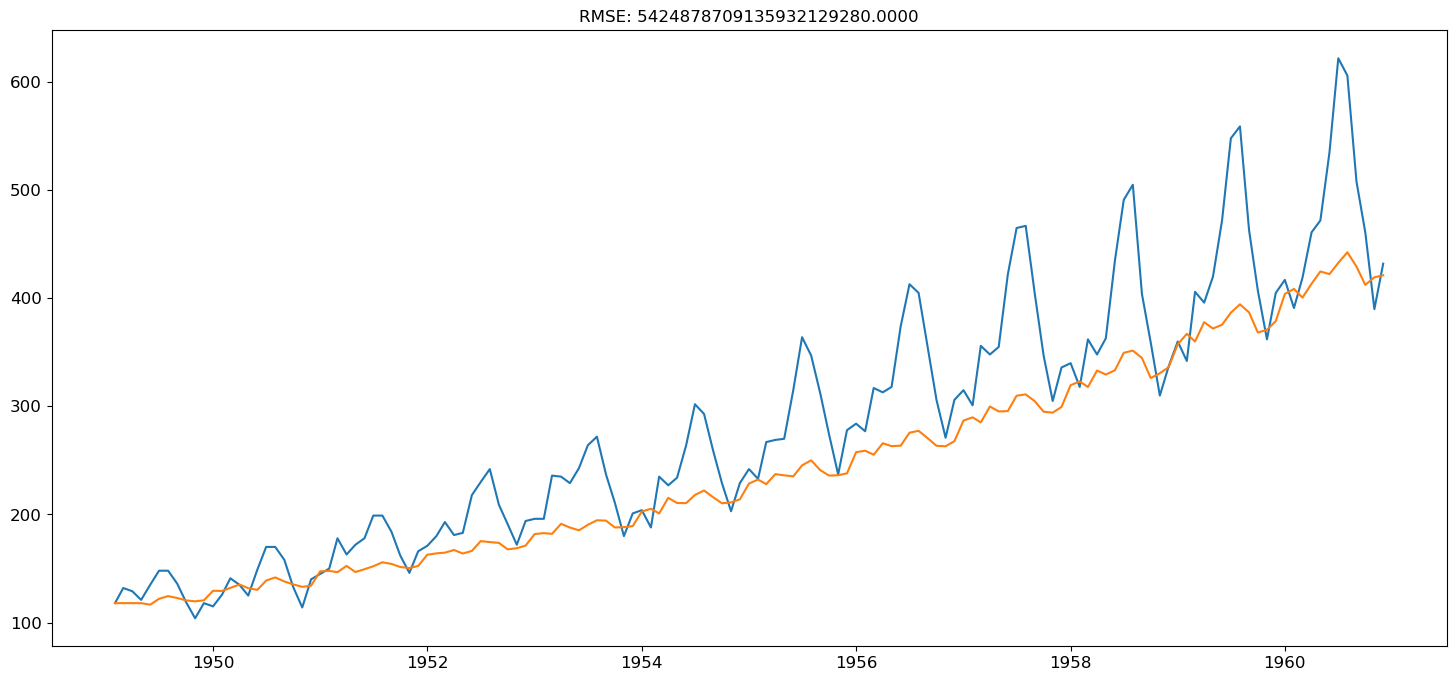

In [41]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**20/len(y.passengers))))
plt.show()

### Métricas de puntuación de calidad de pronóstico

+ **R-cuadrado**
+ **Error absoluto medio**
+ **Median Absolute Error**
+ **Error medio cuadrado**
+ **Error logarítmico medio cuadrado**
+ **Error medio absoluto de porcentaje**


In [42]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error, mean_absolute_percentage_error

**R cuadrado**, coeficiente de determinación (puede interpretarse como un porcentaje de varianza explicado por el modelo), (-inf, 1]

+ sklearn.metrics.r2_score

**Mean Absolute Error**, es una métrica interpretable porque tiene la misma unidad de medida que la serie inicial, [0, +inf)
+ sklearn.metrics.mean_absolute_error

In [43]:
mean_absolute_error(y.passengers, predictions_ARIMA)

42.03035283284027

**Median Absolute Error**, nuevamente una métrica interpretable, particularmente interesante porque es robusta para los valores atípicos, [0,+inf)

+ sklearn.metrics.median_absolute_error

In [44]:
median_absolute_error(y.passengers, predictions_ARIMA)

28.294039423942024

**Mean Squared Error**, más comúnmente usado, da una penalización mayor a los grandes errores y viceversa, [0, + inf)

+ sklearn.metrics.mean_squared_error

In [45]:
mean_squared_error(y.passengers, predictions_ARIMA)

3492.6594568362234

**Error logarítmico medio cuadrado**, practicamente lo mismo que MSE pero inicialmente tomamos el logaritmo de la serie, como resultado también prestamos atención a pequeños errores, generalmente se usa cuando los datos tienen tendencias exponenciales, [0, + inf)

In [46]:
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.03326353693192603

**Error medio porcentual absoluto**, igual que MAE pero porcentaje, -muy conveniente cuando desea explicar la calidad del modelo a su gerencia, [0, +inf),

+ no implementado en sklearn

In [47]:
def mean_absolute_percentage_error (y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

13.295366885465146

**Función para evaluar el pronóstico utilizando las métricas anteriores:**

In [49]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [50]:
evaluate_forecast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.753907,42.030353,28.294039,3492.659457,0.033264,13.295367,59.098726


+ RMSE tiene el beneficio de penalizar más errores grandes, por lo que puede ser más apropiado en algunos casos, por ejemplo, si estar apagado por 10 es más del doble de malo que estar apagado por 5. Pero si estar apagado por 10 es el doble de malo como estar apagado a las 5, entonces MAE es más apropiado.
+ Desde el punto de vista de la interpretación, MAE es claramente el ganador. RMSE no describe solo el error promedio y tiene otras implicaciones que son más difíciles de descrifrar y comprender.
+ Por otro lado, una ventaja distintiva de RMSE sobre MAE es que RMSE evita el uso de tomar el valor absoluto, lo que no es deseable en muchos cálculos matemáticos.

## Media móvil (MA)

+ **Número de términos MA (promedio móvil)(q):** q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x(t) serán e (t-1)... .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.

In [51]:
# MA example
from statsmodels.tsa.arima.model import ARIMA
from random import random

# fit model
model = ARIMA(ts_log_diff, order=(0, 0, 1))
model_fit = model.fit()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [52]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  142
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 120.413
Date:                Tue, 15 Aug 2023   AIC                           -234.826
Time:                        01:22:53   BIC                           -225.959
Sample:                    03-01-1949   HQIC                          -231.223
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0096      0.012      0.813      0.416      -0.014       0.033
ma.L1          0.2709      0.106      2.568      0.010       0.064       0.478
sigma2         0.0107      0.002      5.936      0.000       0.007       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 6.57
Prob(Q):                              0.72   Prob(JB):                         0.04
Heteroskedasticity (H):               1.17   Skew:                             0.22
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'RSS: 1.5249')

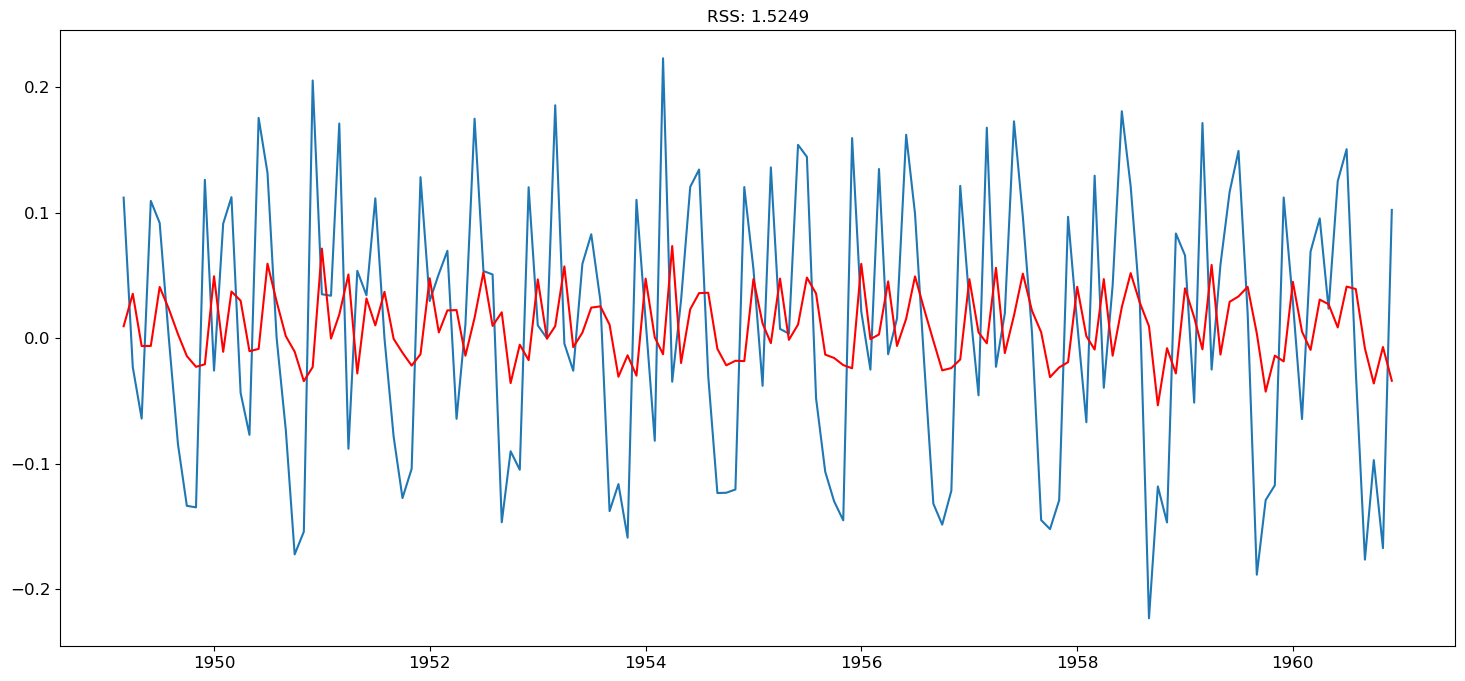

In [53]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Media móvil autorregresiva (ARMA)

+ **Número de términos AR (Auto-regresivos)(p):** p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x (t) serán x (t-1)... .x (t-5).
+ **Número de términos MA (promedio móvil)(q):** q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronósticos rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)... .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.

In [54]:
# ARMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random

# fit model
model = ARIMA(ts_log_diff, order=(2, 0, 1))
model_fit = model.fit()

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [55]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  142
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 138.627
Date:                Tue, 15 Aug 2023   AIC                           -267.253
Time:                        01:22:54   BIC                           -252.474
Sample:                    03-01-1949   HQIC                          -261.248
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.001     15.739      0.000       0.009       0.011
ar.L1          0.9966      0.079     12.571      0.000       0.841       1.152
ar.L2         -0.4118      0.087     -4.759      0.000      -0.581      -0.242
ma.L1         -0.9998      3.478     -0.287      0.774      -7.817       5.817
sigma2         0.0081      0.028      0.291      0.771      -0.046       0.062
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 6.92
Prob(Q):                              0.55   Prob(JB):                         0.03
Heteroskedasticity (H):               1.19   Skew:                             0.11
Prob(H) (two-sided):                  0.56   Kurtosis:                         1.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

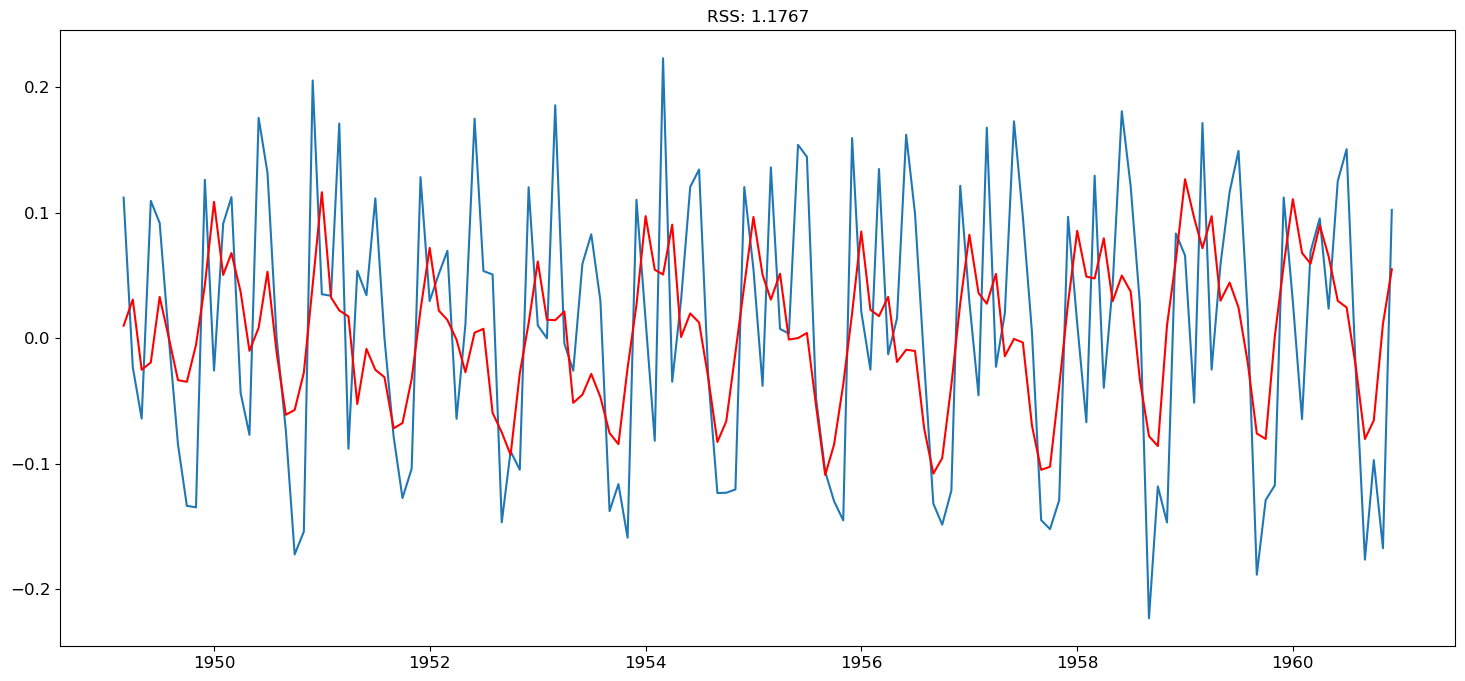

In [56]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

## Media móvil integrada autorregresiva (ARIMA)

En un modelo ARIMA hay 3 parámetros que se utilizan para ayudar a modelar los aspectos principales de una serie de tiempo: estacionalidad, tendencia y ruido. Estos parámetros están etiquetados como p, d y q.

+ **Número de términos AR (Auto-regresivos)(p):** p es el parámetro asociado con el aspecto auto-regresivo del modelo, que incorpora valores pasados, es decir, retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x(t) serán x (t-1)... .x (t-5).
+ **Número de diferencias (d):** d es el parámetro asociado con la parte integrada del modelo, que afecta la cantidad de diferencia que se aplica a una serie de tiempo.
+ **Número de términos MA (promedio móvil)(q):** q es el tamaño de la ventana de parte del promedio móvil del modelo, es decir, errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x (t) serán e (t-1)... .e (t-5) donde e (i) es la diferencia entre el promedio móvil en el valor instantáneo y real.

**Observaciones de EDA en la serie temporal:**

 + La no estaonariedad implica que se requiere al menos un nivel de diferencia (d) en ARIMA
 + El siguiente paso es seleccionar los valores de retraso para los parámetros de Autoregresión (AR) y Media móvil (MA), p y q respectivamente, utilizando gráficos PACF,ACF
 
 Ajuste de los parámetros de ARIMA (https://machinelearningmastery.com/tune-arima-parameters-python/)
 
 Nota: Un problema con ARIMA es que no admite datos estacionales. Esa es una serie de tiempo con un ciclo repetitivo. ARIMA espera datos que no sean estacionales o que eliminen el componente estacional, p. ajustado estacionalmente mediante métodos como la diferenciación estacional.
 
 

In [57]:
ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

**Gráficos ACF y PACF después de diferenciar:**

+ Los intervalos de confianza se dibujan como un cono.
+ De forma predeterminada, esto se establece en un intervalo de confianza del 95%, lo que sugiere que los valores de correlación fuera de este código son muy probablemente una correlación y no una casualidad estadística.
+ Proceso AR (1): tiene un ACF que se reduce y el PACF se corta en el retraso = 1
+ Proceso AR (2): tiene un ACF que se reduce y el PACF se corta en el retraso = 2
+ Proceso MA (1): tiene un corte de ACF en el retraso = 1
+ Proceso MA (2): tiene un corte de ACF en el retraso = 2

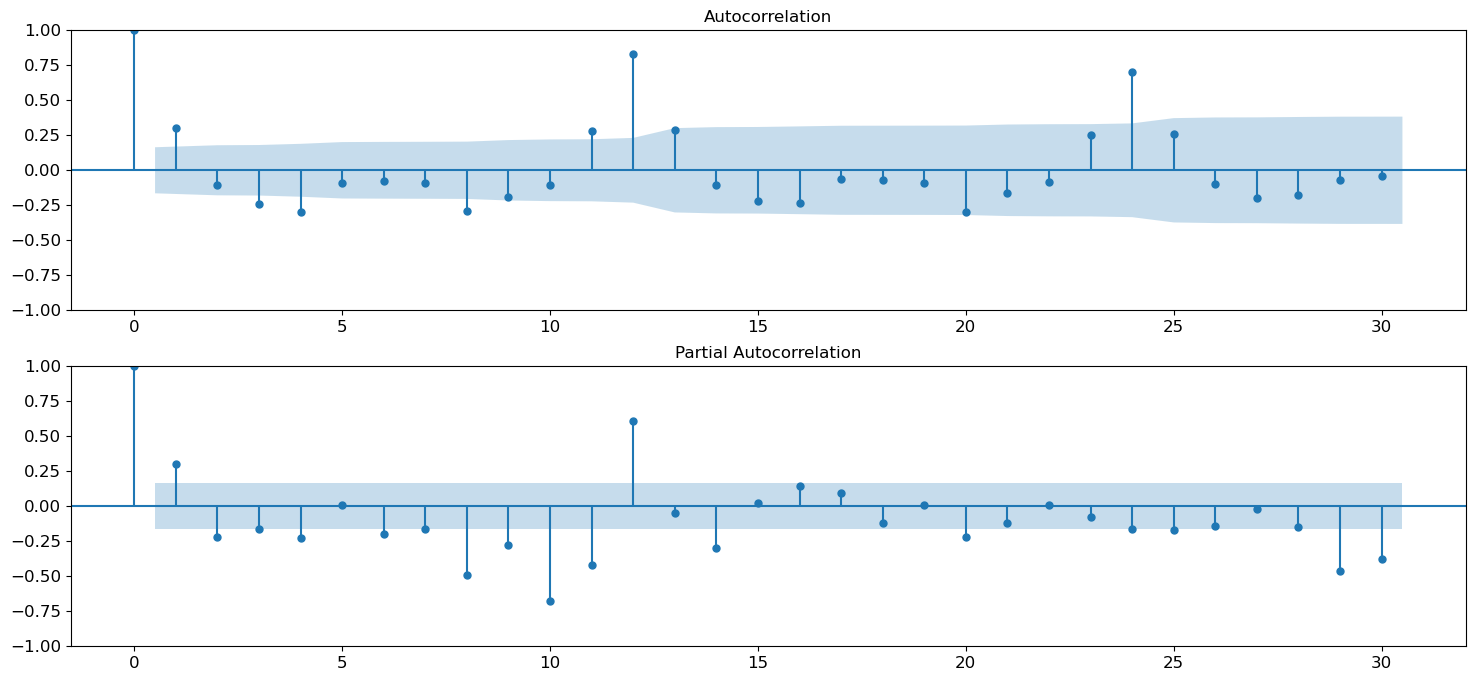

In [58]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(), lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(), lags=30)
pyplot.show()

## Interpretando diagramas ACF

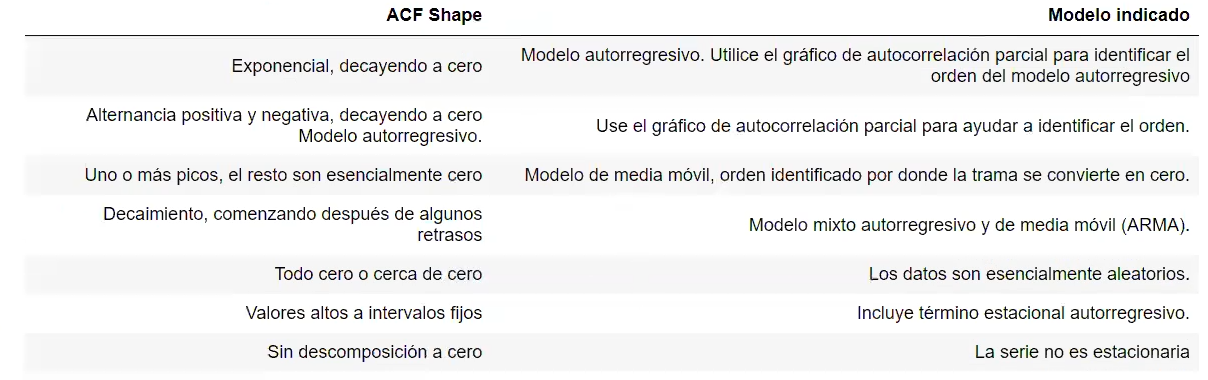

<Axes: xlabel='year'>

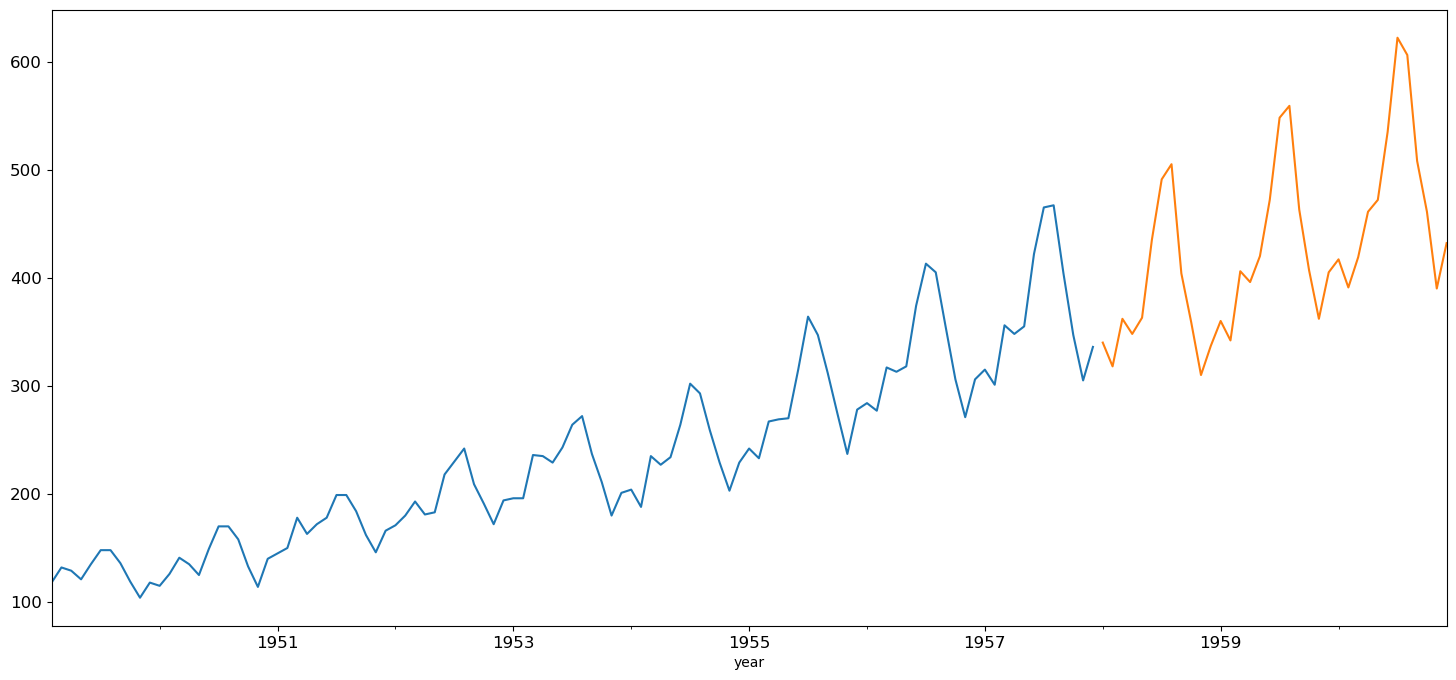

In [59]:
# divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data 
train['passengers'].plot()
valid['passengers'].plot()

## Auto ARIMA

In [60]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [61]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', supress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=951.394, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=994.463, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=988.112, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=983.428, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=993.131, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=980.464, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=975.669, Time=0.10 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.448 second

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

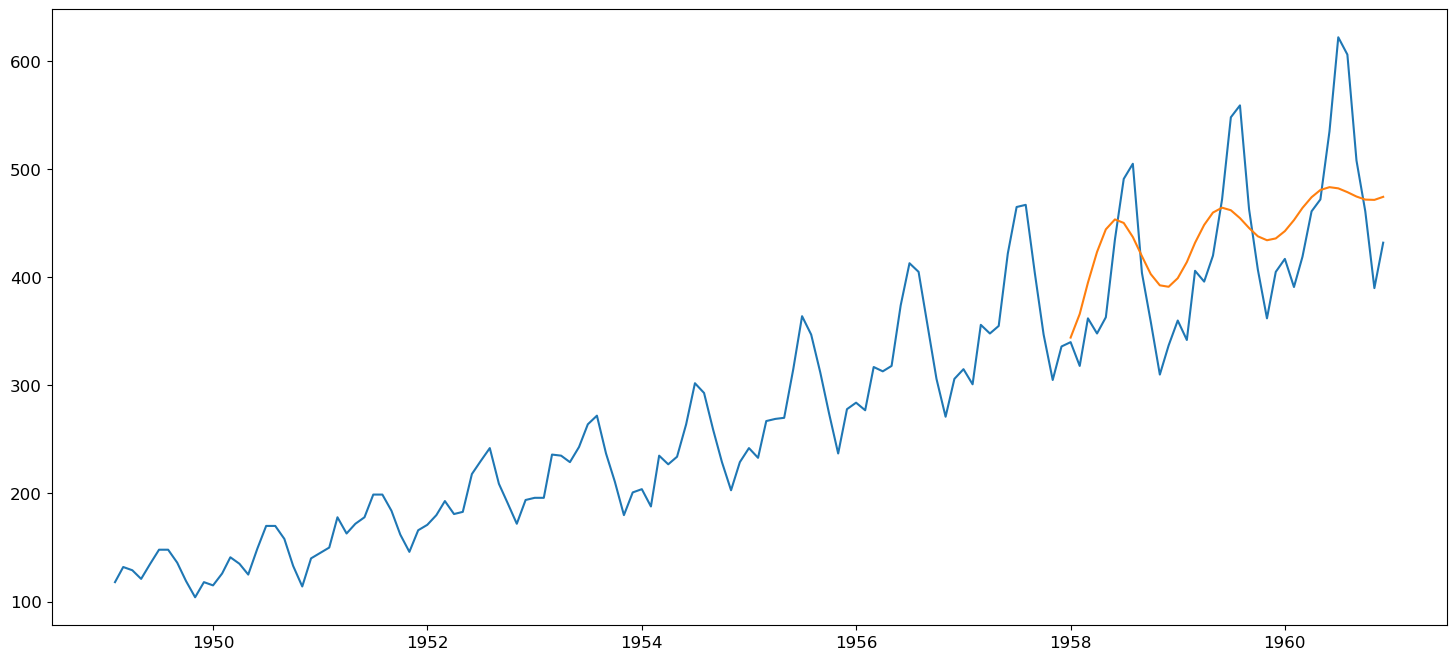

In [62]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediciton')
plt.show()

In [63]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.42529,49.596709,43.172179,3516.251009,0.017671,NaN,59.297985


## Promedio móvil integrado estacional autorregresivo (SARIMA)

El promedio móvil integrado estacional autorregresivo, SARIMA o ARIMA estacional, es una extensión de ARIMA que admite explícitamente datos de series temporales univariantes con un componente estacional.

Agrega tres nuevos hiperparámetros para especificar la autorregresión (AR), la diferenciación (I) y el promedio móvil (MA) para el componente estacional de la serie, así como un parámetro adicional para período de estacionalidad.

**Elementos de tendencia:**

Hay tres elementos de tendencia que requieren configuración. Son los mismos que el modelo ARIMA, específicamente:

+ p: orden de tendencia de autorregresión.
+ d: orden de diferencia de tendencia.
+ q: tendencia de la media móvil.

**Elementos estacionales:**

Hay cuatro elementos estacionales que no forman parte de ARIMA que deben configurarse; son:

+ P: orden autorregresivo estacional.
+ D: orden de diferencia estacional.
+ Q: orden de media móvil estacional.
+ m: el número de pasos de tiempo para un solo periodo estacional. Por ejemplo, una S de 12 para datps mensuales sugiere un ciclo estacional anual.

**Notación SARIMA:** SARIMA (p, d, q) (P, D, Q, m)

In [64]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

#fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [65]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [66]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 23.765239377262958, MSE:564.7866026586099


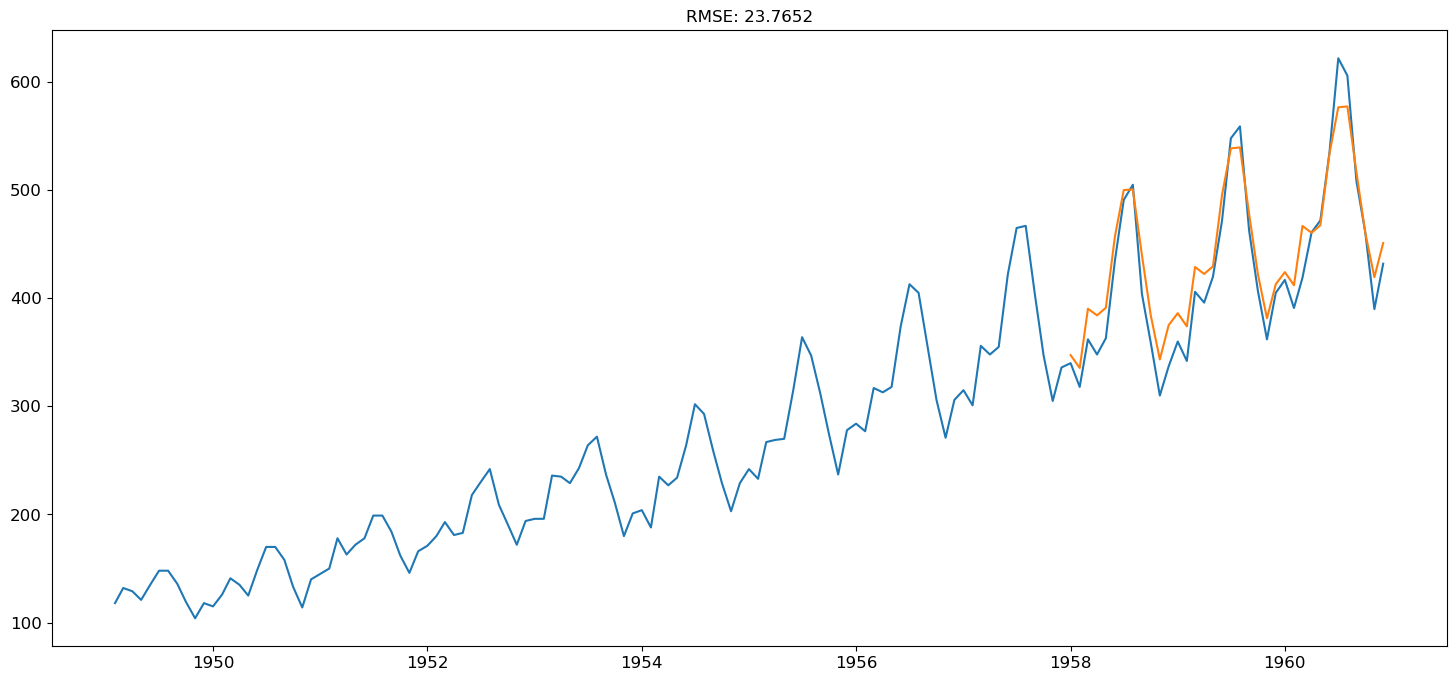

In [67]:
plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [68]:
evaluate_forecast(y[start_index:end_index], predictions)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.907689,20.211335,20.257352,564.786603,0.003365,NaN,23.765239


## Auto - SARIMA
auto arima documentation for selecting best model1

In [69]:
train

,passengers
year,
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
...,...
1957-08-01,467
1957-09-01,404
1957-10-01,347


In [70]:
?auto_arima

In [71]:
# building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warning=True, seasonal=True, m=3)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=994.463, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=988.986, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=985.129, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=993.131, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[3] intercept   : AIC=983.428, Time=0.06 sec
 ARIMA(0,1,1)(1,0,0)[3] intercept   : AIC=985.100, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[3] intercept   : AIC=969.506, Time=0.21 sec
 ARIMA(0,1,1)(2,0,1)[3] intercept   : AIC=967.923, Time=0.28 sec
 ARIMA(0,1,1)(2,0,0)[3] intercept   : AIC=986.889, Time=0.12 sec
 ARIMA(0,1,1)(2,0,2)[3] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(1,0,2)[3] intercept   : AIC=956.429, Time=0.31 sec
 ARIMA(0,1,1)(0,0,2)[3] intercept   : AIC=987.008, Time=0.15 sec
 ARIMA(0,1,0)(1,0,2)[3] intercept   : AIC=957.613, Time=0.20 sec
 ARIMA(1,1,1)(1,0,2)[3] intercept   : AIC=inf, Time=0.3

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(2, 0, 2, 3),
      suppress_warnings=True)

In [72]:
start_index = valid.index.min()
end_index = valid.index.max()

In [73]:
end_index

Timestamp('1960-12-01 00:00:00')

In [74]:
model

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(2, 0, 2, 3),
      suppress_warnings=True)

In [75]:
#Predictions
pred = model.predict()

In [76]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Predictions'])

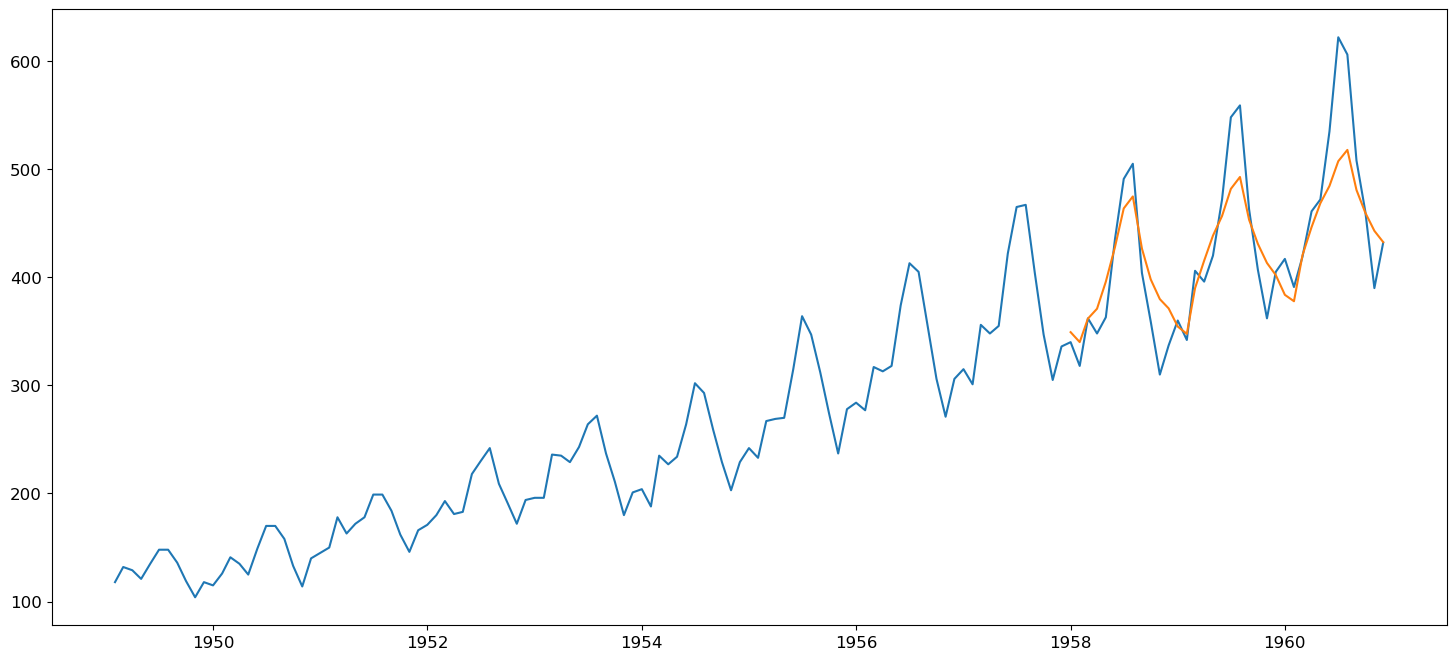

In [77]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [78]:
evaluate_forecast(y[start_index:end_index], forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.755631,28.316848,22.299801,1495.122442,0.007022,NaN,38.666813


## Tuned SARIMA

In [79]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} X {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} X {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} X {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} X {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) X (0, 0, 1, 6)
SARIMAX: (0, 0, 1) X (0, 1, 0, 6)
SARIMAX: (0, 1, 0) X (0, 1, 1, 6)
SARIMAX: (0, 1, 0) X (1, 0, 0, 6)


In [85]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}X{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(0, 0, 0)X(0, 0, 0, 6)12 - AIC:1471.5894402561958
ARIMA(0, 0, 0)X(0, 0, 1, 6)12 - AIC:1319.992881114731
ARIMA(0, 0, 0)X(0, 1, 0, 6)12 - AIC:1096.7826572338538
ARIMA(0, 0, 0)X(0, 1, 1, 6)12 - AIC:1005.4359790042682
ARIMA(0, 0, 0)X(1, 0, 0, 6)12 - AIC:1105.737903034085
ARIMA(0, 0, 0)X(1, 0, 1, 6)12 - AIC:992.5677468085094
ARIMA(0, 0, 0)X(1, 1, 0, 6)12 - AIC:942.2249501685125
ARIMA(0, 0, 0)X(1, 1, 1, 6)12 - AIC:852.1859541586725


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(0, 0, 1)X(0, 0, 0, 6)12 - AIC:1322.590347428562
ARIMA(0, 0, 1)X(0, 0, 1, 6)12 - AIC:1183.157255991753
ARIMA(0, 0, 1)X(0, 1, 0, 6)12 - AIC:989.5448292769476


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(0, 0, 1)X(0, 1, 1, 6)12 - AIC:903.9207098606072
ARIMA(0, 0, 1)X(1, 0, 0, 6)12 - AIC:1009.8928478792919


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)X(1, 0, 1, 6)12 - AIC:906.976084031291
ARIMA(0, 0, 1)X(1, 1, 0, 6)12 - AIC:858.4130159304019


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 0, 1)X(1, 1, 1, 6)12 - AIC:785.0920712348398
ARIMA(0, 1, 0)X(0, 0, 0, 6)12 - AIC:984.4875572346156
ARIMA(0, 1, 0)X(0, 0, 1, 6)12 - AIC:935.3184796718729
ARIMA(0, 1, 0)X(0, 1, 0, 6)12 - AIC:989.8626044820674
ARIMA(0, 1, 0)X(0, 1, 1, 6)12 - AIC:845.5177330594203
ARIMA(0, 1, 0)X(1, 0, 0, 6)12 - AIC:943.8322183884749


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(0, 1, 0)X(1, 0, 1, 6)12 - AIC:895.3070514556579
ARIMA(0, 1, 0)X(1, 1, 0, 6)12 - AIC:700.1868931522525
ARIMA(0, 1, 0)X(1, 1, 1, 6)12 - AIC:694.5935065735149
ARIMA(0, 1, 1)X(0, 0, 0, 6)12 - AIC:964.9494014568144
ARIMA(0, 1, 1)X(0, 0, 1, 6)12 - AIC:916.1835214164015
ARIMA(0, 1, 1)X(0, 1, 0, 6)12 - AIC:970.2058039298523


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(0, 1, 1)X(0, 1, 1, 6)12 - AIC:829.3905974836747
ARIMA(0, 1, 1)X(1, 0, 0, 6)12 - AIC:933.197196217332
ARIMA(0, 1, 1)X(1, 0, 1, 6)12 - AIC:879.2724953159874


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(0, 1, 1)X(1, 1, 0, 6)12 - AIC:691.8986810545535


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 1)X(1, 1, 1, 6)12 - AIC:676.1162625883272
ARIMA(1, 0, 0)X(0, 0, 0, 6)12 - AIC:995.0872335459023
ARIMA(1, 0, 0)X(0, 0, 1, 6)12 - AIC:946.0281737913417
ARIMA(1, 0, 0)X(0, 1, 0, 6)12 - AIC:992.3210476491303


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

ARIMA(1, 0, 0)X(0, 1, 1, 6)12 - AIC:854.1006983844103
ARIMA(1, 0, 0)X(1, 0, 0, 6)12 - AIC:945.8249949151767


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)X(1, 0, 1, 6)12 - AIC:897.23329536793
ARIMA(1, 0, 0)X(1, 1, 0, 6)12 - AIC:700.7529216471503


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 0)X(1, 1, 1, 6)12 - AIC:700.9426911399986
ARIMA(1, 0, 1)X(0, 0, 0, 6)12 - AIC:975.3565669152882


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.w

ARIMA(1, 0, 1)X(0, 0, 1, 6)12 - AIC:927.1015530645024
ARIMA(1, 0, 1)X(0, 1, 0, 6)12 - AIC:967.4612507661526
ARIMA(1, 0, 1)X(0, 1, 1, 6)12 - AIC:836.8512489510257
ARIMA(1, 0, 1)X(1, 0, 0, 6)12 - AIC:935.2083535894947
ARIMA(1, 0, 1)X(1, 0, 1, 6)12 - AIC:876.2562823874398


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)X(1, 1, 0, 6)12 - AIC:693.6979953241676


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)X(1, 1, 1, 6)12 - AIC:684.4099920835943
ARIMA(1, 1, 0)X(0, 0, 0, 6)12 - AIC:977.9057542721393
ARIMA(1, 1, 0)X(0, 0, 1, 6)12 - AIC:928.7238491320232
ARIMA(1, 1, 0)X(0, 1, 0, 6)12 - AIC:976.0432050448768
ARIMA(1, 1, 0)X(0, 1, 1, 6)12 - AIC:835.8882808221339


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(1, 1, 0)X(1, 0, 0, 6)12 - AIC:927.7462242532082
ARIMA(1, 1, 0)X(1, 0, 1, 6)12 - AIC:885.4070402292064
ARIMA(1, 1, 0)X(1, 1, 0, 6)12 - AIC:686.2396845892459


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(1, 1, 0)X(1, 1, 1, 6)12 - AIC:684.1667526008783
ARIMA(1, 1, 1)X(0, 0, 0, 6)12 - AIC:962.9055074926864
ARIMA(1, 1, 1)X(0, 0, 1, 6)12 - AIC:913.1794953063206


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(1, 1, 1)X(0, 1, 0, 6)12 - AIC:969.0402471857326
ARIMA(1, 1, 1)X(0, 1, 1, 6)12 - AIC:832.770226318392
ARIMA(1, 1, 1)X(1, 0, 0, 6)12 - AIC:921.9213046743026


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA(1, 1, 1)X(1, 0, 1, 6)12 - AIC:878.848272382656
ARIMA(1, 1, 1)X(1, 1, 0, 6)12 - AIC:686.7731070449665


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)X(1, 1, 1, 6)12 - AIC:678.02223554316
